# Environment
First of all, we'd better declare the working environment, including the version of Python and packages used. We use [watermark](https://github.com/rasbt/watermark) package to printe date and time stamps, version numbers, and hardware information.

In [68]:
%load_ext watermark
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse 
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix as sm
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2018-09-24T21:46:42+08:00

CPython 3.6.5
IPython 6.4.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [69]:
%watermark -p matplotlib,numpy,pandas,scipy,seaborn,sklearn

matplotlib 2.2.3
numpy 1.15.1
pandas 0.23.0
scipy 1.1.0
seaborn 0.9.0
sklearn 0.19.1


In this project, we will take use some self-defined functions to plot the 2-D K-Means and Gaussian Mixture Model (GMM).

In [70]:
# k-means weaknesses that mixture models address directly
# code sourced from:
#   http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb

# Predefined parameters
def plot_kmeans(kmeans, X, n_clusters, rseed=2, ax=None):
    dot_size = 50
    cmap = 'viridis'
    labels = kmeans.fit_predict(X)
    
    # plot input data
    #ax = ax or plt.gca() # <-- nice trick
    fig, ax = plt.subplots(figsize=(9,7))    
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1],
               c=labels, s=dot_size, cmap=cmap, zorder=2)
    
    # plot the representation of Kmeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels==i], [center]).max() 
             for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC',edgecolor='slategrey',
                                lw=4, alpha=0.5, zorder=1))
    return  

# code sourced from:
# http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.12-Gaussian-Mixtures.ipynb
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                            angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    dot_size = 50
    cmap = 'viridis'
    
    fig, ax = plt.subplots(figsize=(9,7))      
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=dot_size, cmap=cmap, zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=dot_size, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax=ax, alpha=w * w_factor)

# Import Data
In this project, we use [Wine Dataset](http://archive.ics.uci.edu/ml/datasets/Wine) to cluster different types of wines. This data set contains the results of a chemical analysis of wines grown in a specific area of Italy.

The attributes are (dontated by Riccardo Leardi, riclea@anchem.unige.it ):
1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash  
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline 

Variable `Label` include the true labels of different wine.

In [71]:
wine = pd.read_csv('wine.data', \
                   names = ['Label', \
                            'Alcohol', \
                            'Malic acid', \
                            'Ash', \
                            'Alcalinity of ash', \
                            'Magnesium', \
                            'Total phenols', \
                            'Flavanoids', \
                            'Nonflavanoid phenols', \
                            'Proanthocyanins', \
                            'Color intensity', \
                            'Hue', \
                            'OD280', \
                            'Proline'])
# True labels
label = wine['Label']
del wine['Label']
# Data description
print("Types of variables:\n",wine.dtypes)

wine.describe()

Types of variables:
 Alcohol                 float64
Malic acid              float64
Ash                     float64
Alcalinity of ash       float64
Magnesium                 int64
Total phenols           float64
Flavanoids              float64
Nonflavanoid phenols    float64
Proanthocyanins         float64
Color intensity         float64
Hue                     float64
OD280                   float64
Proline                   int64
dtype: object


Alcohol  Malic acid         Ash  Alcalinity of ash   Magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       Color intensity         Hue       OD280      Proline  
count       178.000000  178.000000  178.000000   178.000000  
mean          5.058090    0.957449    2.611685   746.893258  
std           2.318286    0.228572    0.709990   314.907474  
min           1.280000    0.480000    1.270000   278.000000  
25%           3.220000    0.782500    1.937500   500.500000  
50%           4.690000    0.965000    2.780000   673.500000  
75%           6.200000    1.120000    3.170000   985.000000  
max          13.000000    1.710000    4.000000  1680.000000

From the table above we can get that there are 178 instances of wine and 13 attributes and for each attribute, the distribution differ a lot. Then we are going to plot the scatter plot of the dataset `wine` as follow:

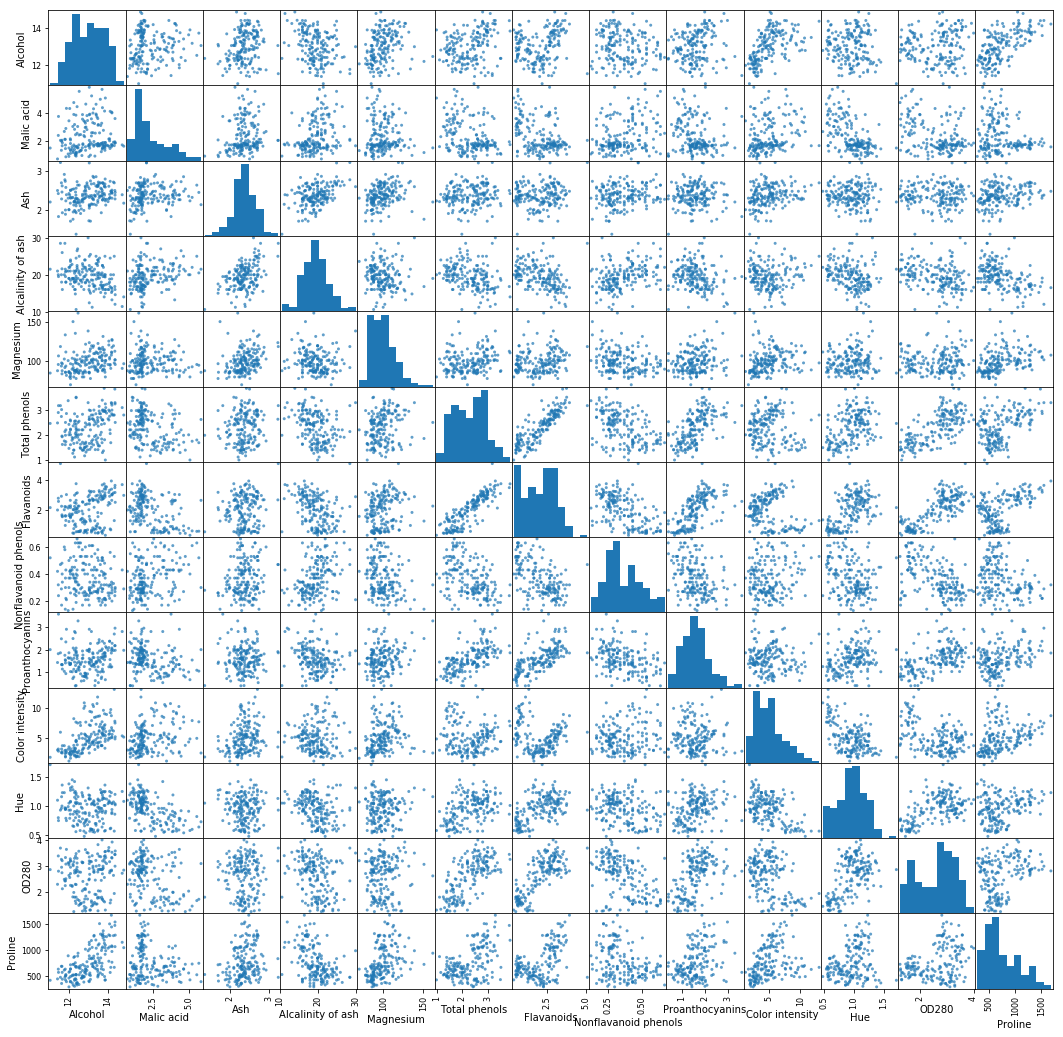

In [72]:
# Scatter plot
sm(wine, alpha = 0.7, figsize = (18,18))
plt.show()

From the scatter plot, it's hard for us to cluster the data.

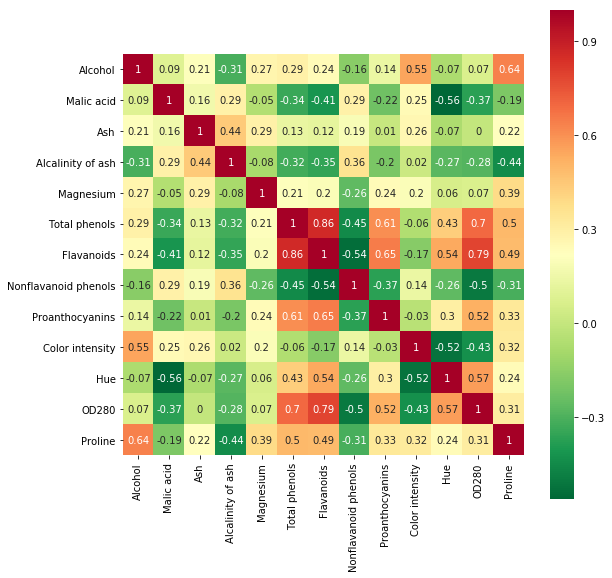

In [73]:
# Correlation Heatmap
correlation = wine.corr()
plt.subplots(figsize = (9,9))
sns.heatmap(correlation.round(2), 
            annot = True, 
            vmax = 1, 
            square = True, 
            cmap = 'RdYlGn_r')
plt.show()

From the heatmap above, we can conclude that the correlation between

* "Flavanoids" and "Total phenols" (`0.86`);
* "OD280" and "Flavanoids" (`0.79`);
* "OD280" and "Total phenols" (`0.7`);

are large.

Then we can plot the regression of "Flavanoids" on "Total phenols" as follow:

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


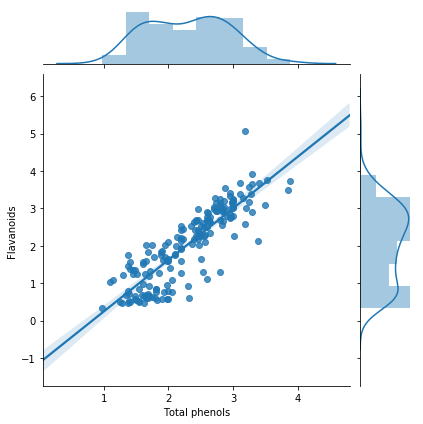

In [74]:
# regression
sns.jointplot(x=wine.columns[5], 
              y=wine.columns[6], 
              data=wine, 
              kind="reg");
plt.show()

## Normalize data

We are going to normalize data by removing the mean and scaling to unit variance using `preprocessing.StandardScaler` and the table below show the general description statistics of normalized data.

In [75]:
scaler = preprocessing.StandardScaler()
scaler.fit(wine)
X_scaled_array = scaler.transform(wine)
winenorm = pd.DataFrame(X_scaled_array, columns = wine.columns)
winenorm.head()

Alcohol  Malic acid       Ash  Alcalinity of ash  Magnesium  \
0  1.518613   -0.562250  0.232053          -1.169593   1.913905   
1  0.246290   -0.499413 -0.827996          -2.490847   0.018145   
2  0.196879    0.021231  1.109334          -0.268738   0.088358   
3  1.691550   -0.346811  0.487926          -0.809251   0.930918   
4  0.295700    0.227694  1.840403           0.451946   1.281985   

   Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  \
0       0.808997    1.034819             -0.659563         1.224884   
1       0.568648    0.733629             -0.820719        -0.544721   
2       0.808997    1.215533             -0.498407         2.135968   
3       2.491446    1.466525             -0.981875         1.032155   
4       0.808997    0.663351              0.226796         0.401404   

   Color intensity       Hue     OD280   Proline  
0         0.251717  0.362177  1.847920  1.013009  
1        -0.293321  0.406051  1.113449  0.965242  
2         0.269020  0.318304  0.788587  1.395148  
3         1.186068 -0.427544  1.184071  2.334574  
4        -0.319276  0.362177  0.449601 -0.037874

# [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)

In this part, we are going to cluster the `winenorm` dataset using K-Means method. The KMeans algorithm clusters data by trying to separate samples in `n` groups of equal variance, minimizing a criterion known as the **inertia** or within-cluster sum-of-squares (WSS).

## Choosing number of cluster

### Elbow Method

First of all, we are going to choose the number of cluster by [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 

Inertia is sum of squared distances of samples to their closest cluster center. And the Elbow method looks at the inertia as a function of the number of clusters. One should choose a number of clusters so that adding another cluster doesn’t improve much better the inertia.



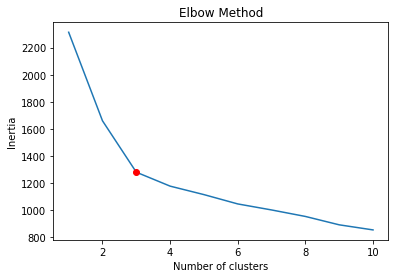

In [76]:
#Elbow Method
seed = 0
elbow = dict()
for k in range(1,11):
    estimator = KMeans(n_clusters = k,random_state=seed)
    res = estimator.fit_predict(winenorm)
    inertia = estimator.inertia_
    elbow[k] = inertia
    
elbow_df = pd.Series(elbow)
ax = elbow_df.plot(title = 'Elbow Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
plt.plot(3,elbow_df[3],'ro')

From the figure above, we can see that when the number of cluster is 3, it's hard to tell whether adding another cluster can improve much better the inertia or not.

### Average silhouette method

The [Silhouette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) is calculated using the mean intra-cluster distance (`a`) and the mean nearest-cluster distance (`b`) for each sample. The Silhouette Coefficient for a sample is `(b - a) / max(a, b)`. It measures the quality of a clustering.

Average silhouette method computes the average silhouette of observations for different values of k. The optimal number of clusters k is the one that maximize the average silhouette over a range of possible values for k (Kaufman and Rousseeuw 1990).

For n_clusters = 2 The average silhouette_score is : 0.2683134097105213


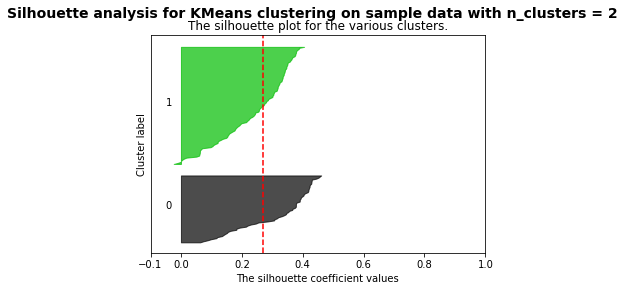

For n_clusters = 3 The average silhouette_score is : 0.28594199657074876


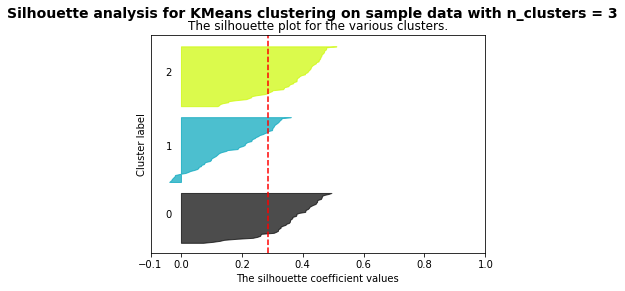

For n_clusters = 4 The average silhouette_score is : 0.25173343011696475


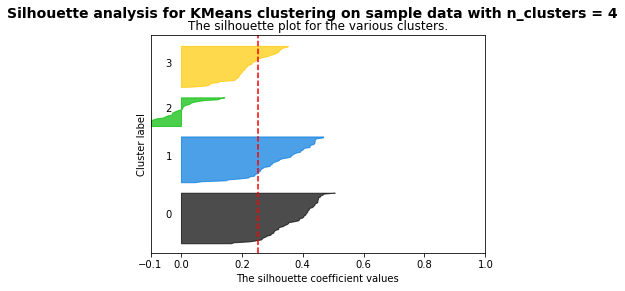

For n_clusters = 5 The average silhouette_score is : 0.23187479572412723


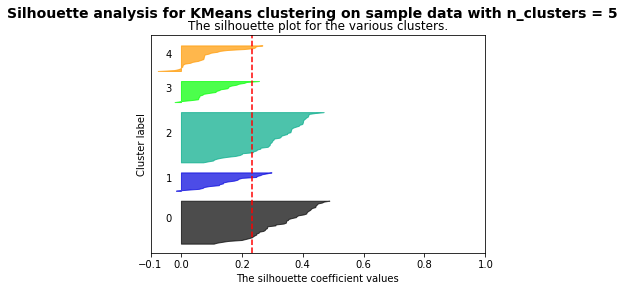

For n_clusters = 6 The average silhouette_score is : 0.23964277899912415


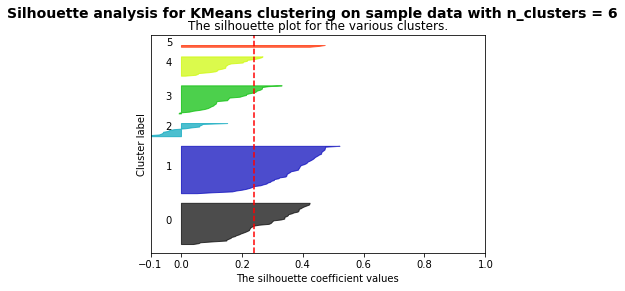

For n_clusters = 7 The average silhouette_score is : 0.1977124515910614


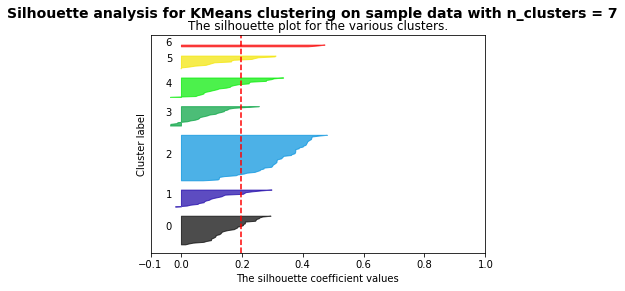

For n_clusters = 8 The average silhouette_score is : 0.133114891253478


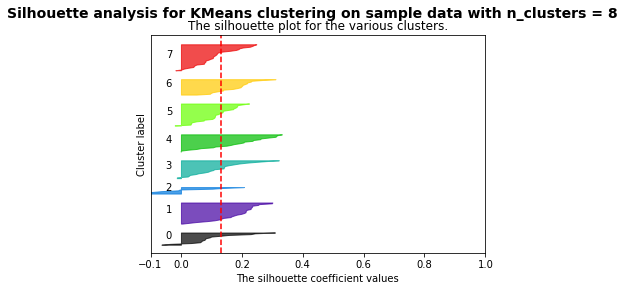

For n_clusters = 9 The average silhouette_score is : 0.14035373736325835


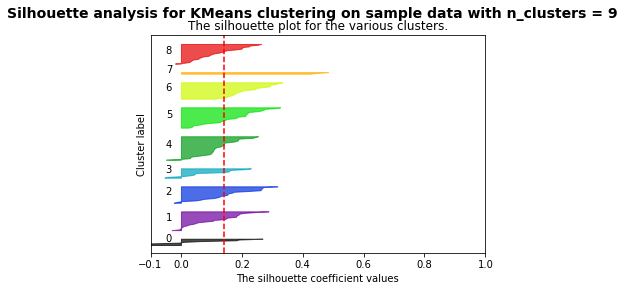

For n_clusters = 10 The average silhouette_score is : 0.14398677296462006


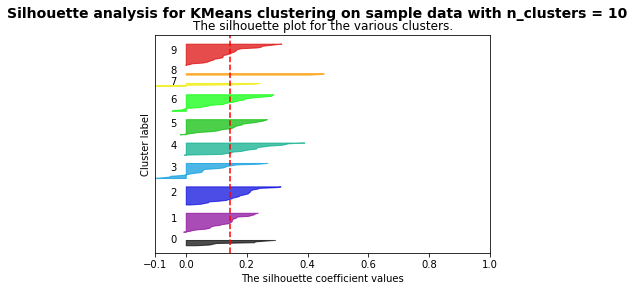

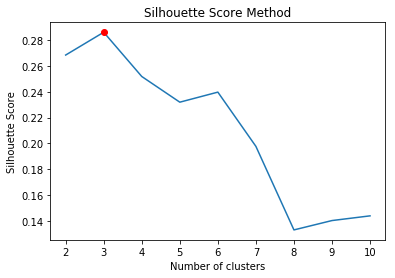

In [77]:
# Silhouette Score Method
seed = 0
dict_silhouette_avg = dict()
range_n_clusters = range(2,11)

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, winenorm.shape[0] + (n_clusters + 1) * 10])
    
    estimator = KMeans(n_clusters = n_clusters,random_state=seed)
    cluster_labels = estimator.fit_predict(winenorm)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(winenorm,cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    dict_silhouette_avg[n_clusters] = silhouette_avg
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(winenorm,cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
silhouette_df = pd.Series(dict_silhouette_avg)
ax = silhouette_df.plot(title = 'Silhouette Score Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette Score')
plt.plot(3,silhouette_df[3],'ro')

From the figure above, we can see that when the number of cluster is 3, average silhouette score is maximized.

Thus we choose the number of cluster to be **3**.

## K-Means

In [78]:
KM = KMeans(n_clusters = 3, random_state=seed)
res = KM.fit_predict(winenorm)

label_pred_KM = KM.labels_
print("Labels predicted by K-Means:",label_pred_KM)
print('Length of labels is same as data entry', label_pred_KM.shape)

centroids_KM= KM.cluster_centers_
print("Shape of centroids_KM",centroids_KM.shape)
print("Centroids:",centroids_KM)

inertia_KM = KM.inertia_
print("Inertia:",inertia_KM)

Labels predicted by K-Means: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Length of labels is same as data entry (178,)
Shape of centroids_KM (3, 13)
Centroids: [[ 0.16490746  0.87154706  0.18689833  0.52436746 -0.07547277 -0.97933029
  -1.21524764  0.72606354 -0.77970639  0.94153874 -1.16478865 -1.29241163
  -0.40708796]
 [-0.93900326 -0.39196582 -0.43920097  0.20898793 -0.46377382 -0.05334831
   0.06690377 -0.01982215  0.06479192 -0.88207529  0.45298189  0.28973833
  -0.75602559]
 [ 0.87809728 -0.30457633  0.31894179 -0.66452366  0.56488825  0.87650546
   0.94363903 -0.58558981  0.58178294  0.16718842  0.48372814  0.76705349
   1.15834713]]
Inertia: 1278.7607763668143


We can plot the pairwise relationships of `winenorm` with the colored label predicted bt K-Means method.

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

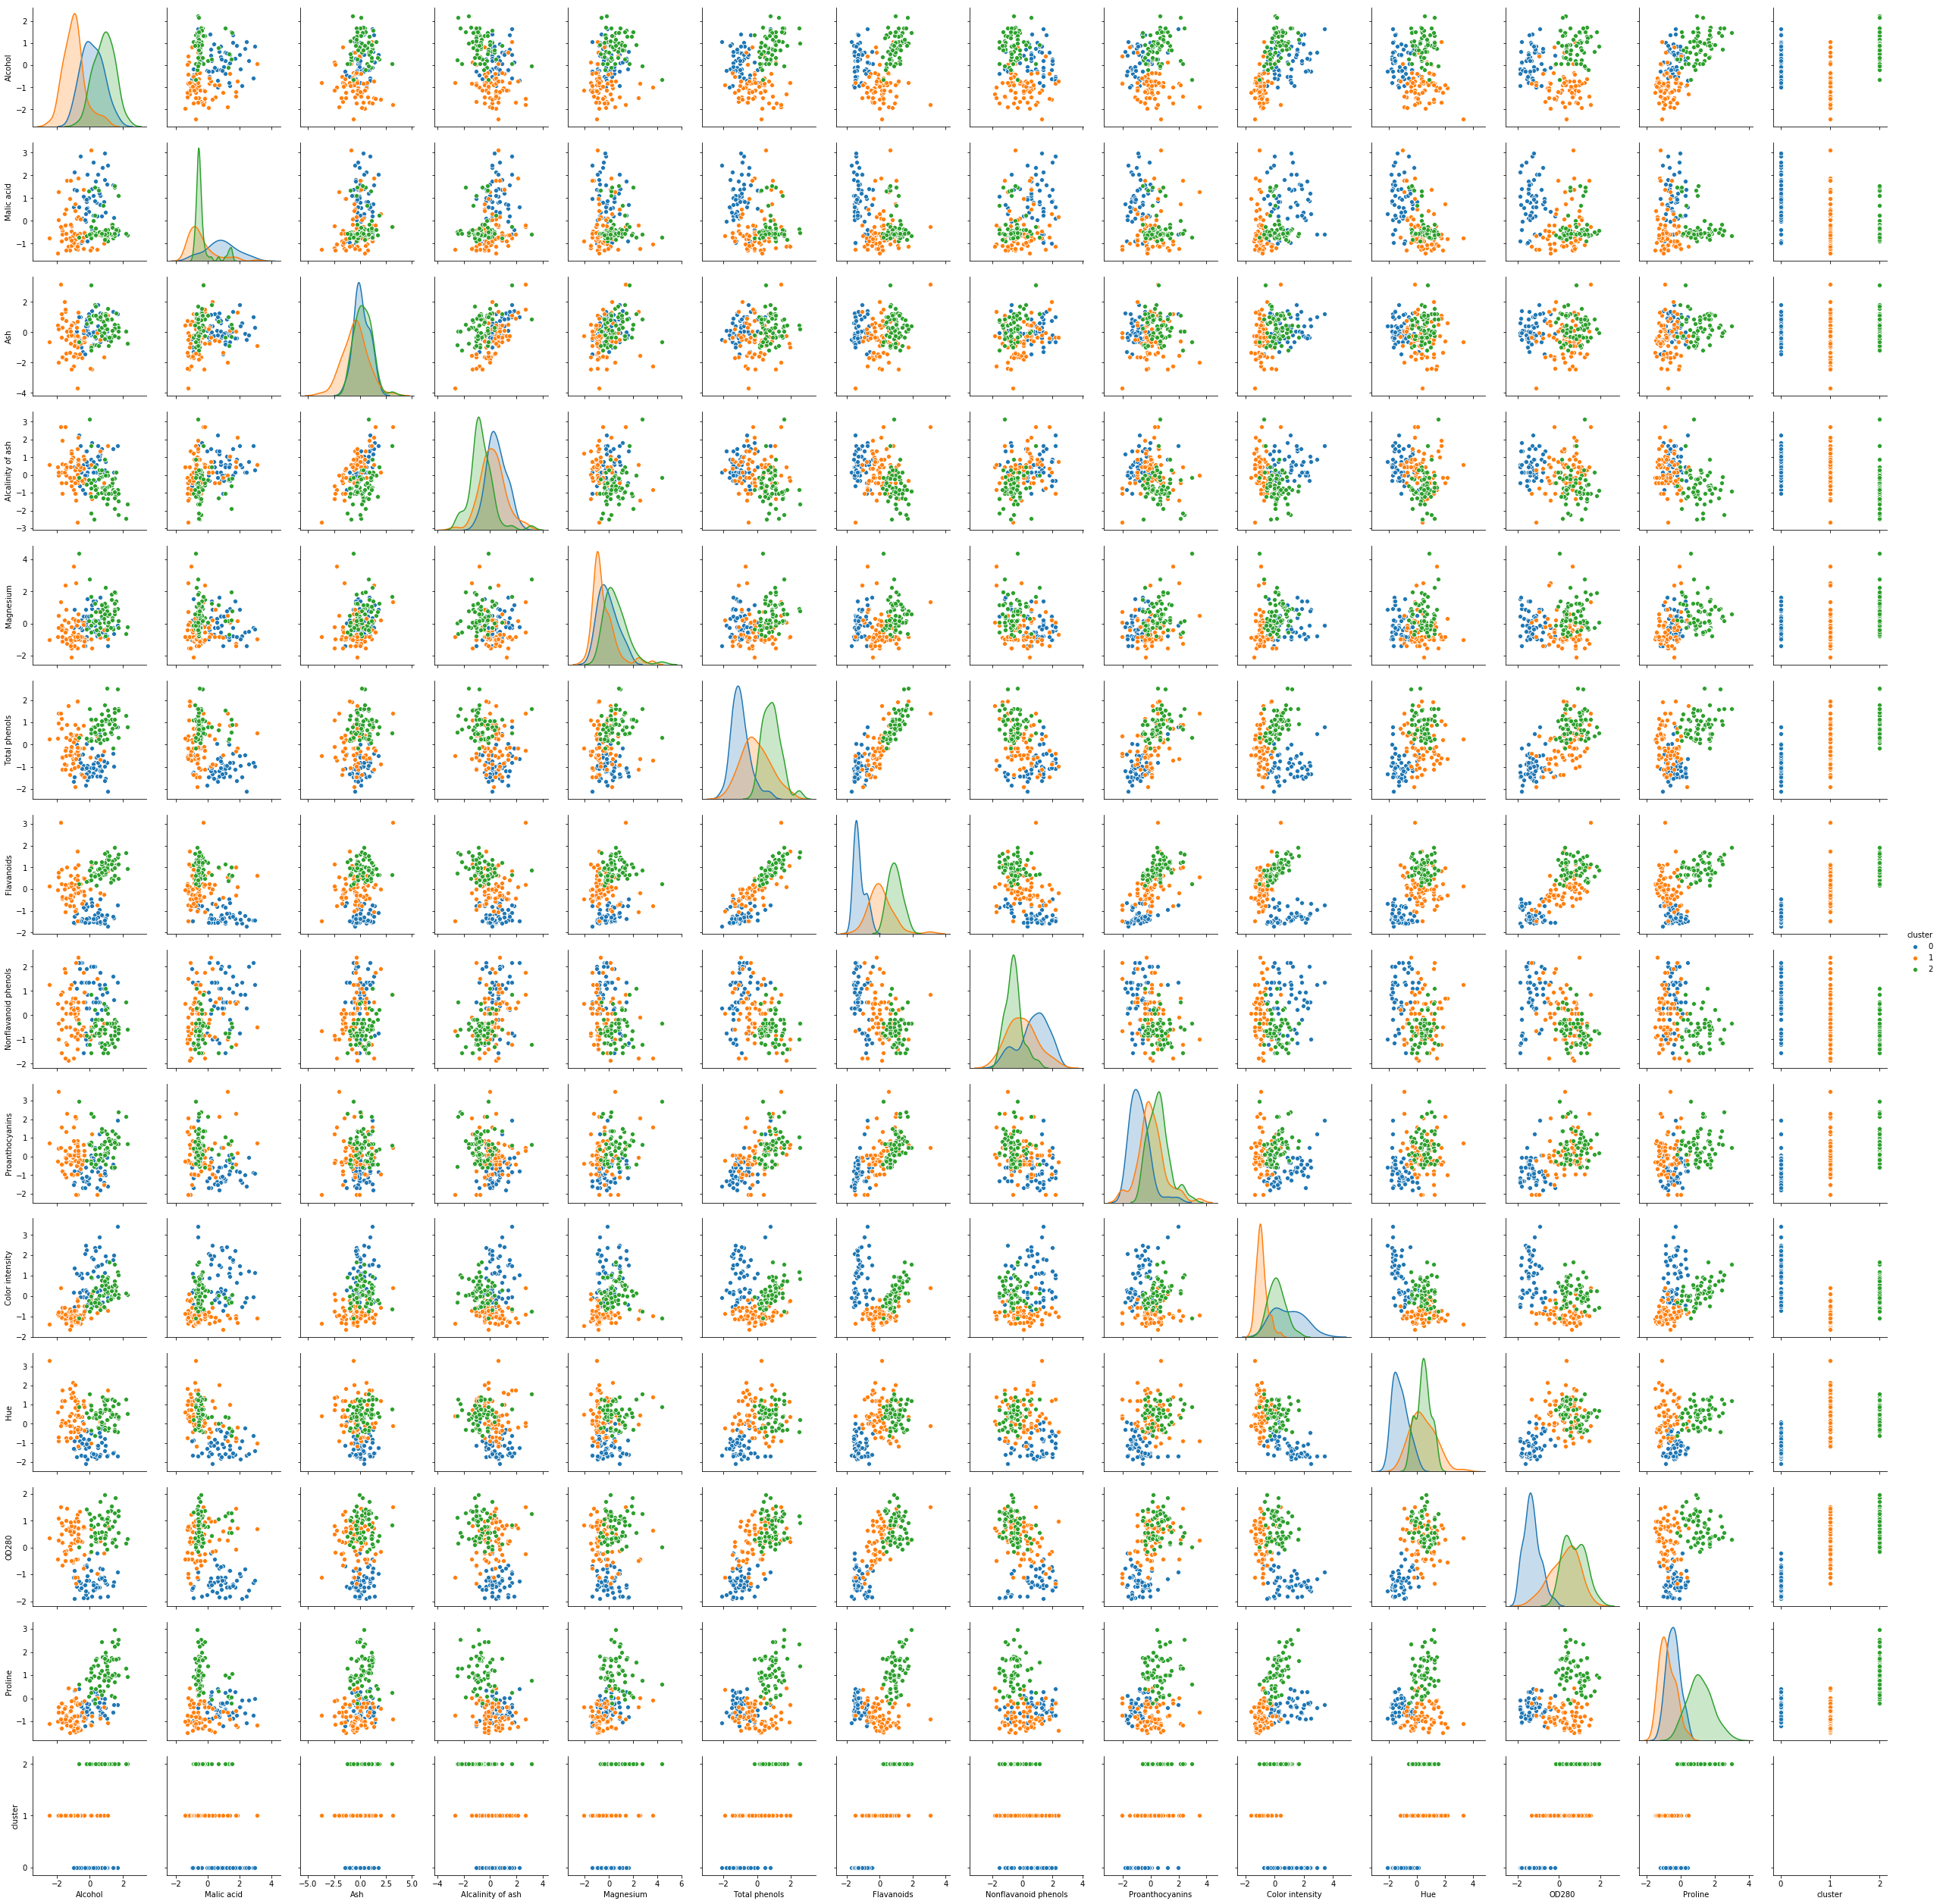

In [79]:
# Pairplot
winenorm['cluster'] = label_pred_KM.astype(str)
sns_plot = sns.pairplot(winenorm, hue = "cluster")

# Gaussian Mixture Model

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

In this project, we take use of `GaussianMixture` from `sklearn` package. The `GaussianMixture` object implements the expectation-maximization (EM) algorithm for fitting mixture-of-Gaussian models. 

## Choosing number of cluster

We use [Akaike information criterion (AIX)](https://en.wikipedia.org/wiki/Akaike_information_criterion) AND [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion) as criteria to select optimal number of clusters. The optimal number of clusters is the number that with minimum AIC/BIC.

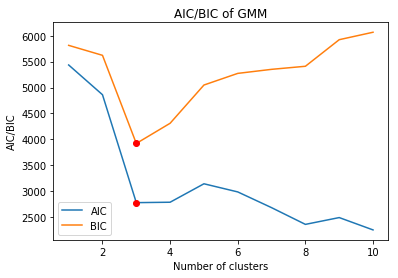

In [80]:
aic = dict()
bic = dict()
for k in range(1,11):
	estimator = GaussianMixture(n_components = k, random_state=seed)
	res = estimator.fit(winenorm)
	ic1 = estimator.aic(winenorm)
	ic2 = estimator.bic(winenorm)
	aic[k] = ic1
	bic[k] = ic2
    
aic_df = pd.Series(aic)
bic_df = pd.Series(bic)

temp = {'AIC' : aic_df,
     'BIC' : bic_df}
ic_df = pd.DataFrame(temp)
ax = ic_df.plot(title='AIC/BIC of GMM')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('AIC/BIC')
plt.plot(3,aic_df[3],'ro')
plt.plot(3,bic_df[3],'ro')

From the figure above, we can see that considering both AIC and BIC, the number of clusters should be **3**.

## Gaussian Mixture Model


In [81]:
GMM = GaussianMixture(n_components = 3, random_state=seed)
res_GMM = GMM.fit(winenorm)

weights_GMM = GMM.weights_
print("Weights:",weights_GMM)
means_GMM = GMM.means_
print("Means:",means_GMM)
covariance_GMM = GMM.covariances_
print("Type of covariance_GMM:",type(covariance_GMM))
covariance_GMM.size

label_pred_GMM = GMM.predict(winenorm)
print("Labels predicted by GMM:",label_pred_GMM)
print('Length of labels is same as data entry', label_pred_GMM.shape)

Weights: [0.28651685 0.37078652 0.34269663]
Means: [[ 0.16490746  0.87154706  0.18689833  0.52436746 -0.07547277 -0.97933029
  -1.21524764  0.72606354 -0.77970639  0.94153874 -1.16478865 -1.29241163
  -0.40708796  0.        ]
 [-0.93900326 -0.39196582 -0.43920097  0.20898793 -0.46377382 -0.05334831
   0.06690377 -0.01982215  0.06479192 -0.88207529  0.45298189  0.28973833
  -0.75602559  1.        ]
 [ 0.87809728 -0.30457633  0.31894179 -0.66452366  0.56488825  0.87650546
   0.94363903 -0.58558981  0.58178294  0.16718842  0.48372814  0.76705349
   1.15834713  2.        ]]
Type of covariance_GMM: <class 'numpy.ndarray'>
Labels predicted by GMM: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

We can plot the pairwise relationships of `winenorm` with the colored label predicted bt GMM method.

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

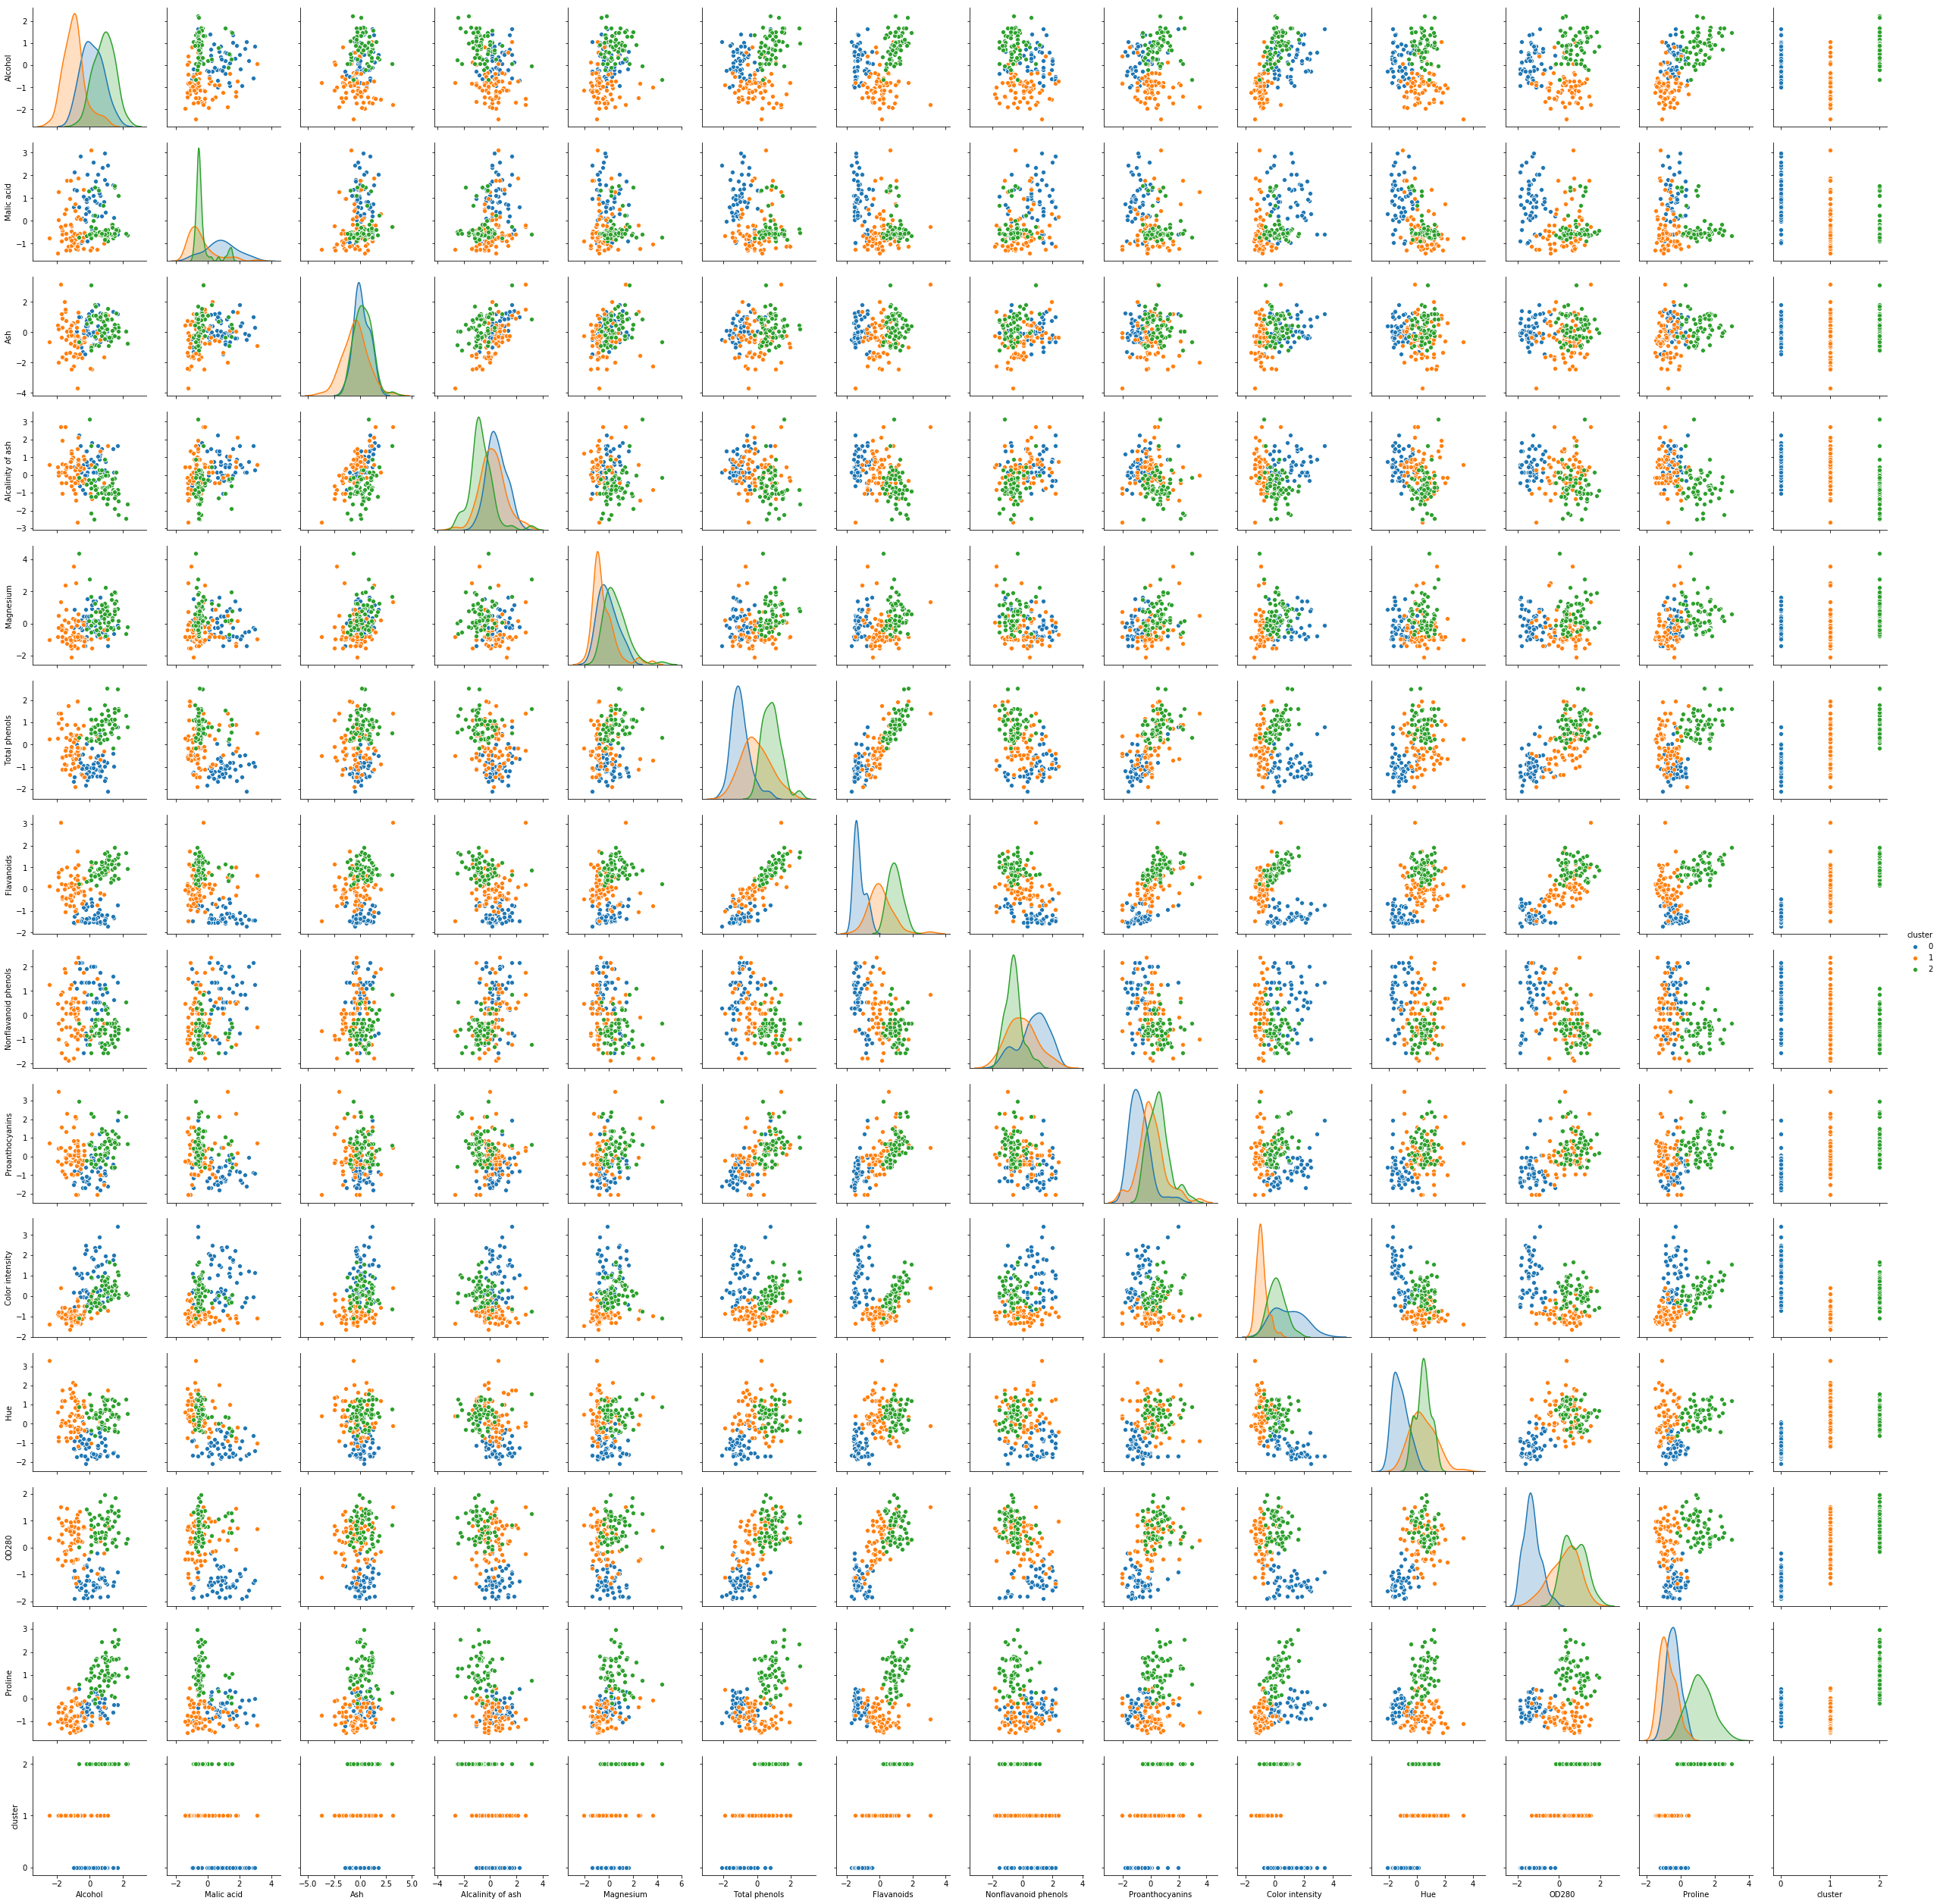

In [82]:
winenorm['cluster'] = label_pred_GMM.astype(str)
sns_plot = sns.pairplot(winenorm, hue = "cluster")
#sns_plot.fig.suptitle("Pair ploy",fontsize=14, fontweight='bold')

# [Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)

We can take use of PCA to reduce the dimension of dataset.

First of all, we are going to generate the 13 Principal Component (PA) of `winenorm` and check the amount and percentage of of variance explained by each of the selected components.

Then we will compute the singular values corresponding to each of the selected components. 

In [83]:
pca = PCA(random_state=seed)
pca.fit(winenorm)
winenorm_pca_array = pca.transform(winenorm)
winenorm_pca = pd.DataFrame(winenorm_pca_array)
print("Heads of wine_pca:",winenorm_pca.head())
var_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:",var_ratio)
sv = pca.singular_values_
print("Singular Value:",sv)

Heads of wine_pca:          0         1         2         3         4         5         6   \
0 -3.445737 -1.443130 -0.181606 -0.141619  0.719226 -0.240562  0.571670   
1 -2.399645  0.333539 -2.023331 -0.354329 -0.283459 -0.921755 -0.004363   
2 -2.686493 -1.030953  0.973409  0.723016 -0.287199  0.496867  0.469883   
3 -3.857784 -2.755956 -0.199499  0.592766 -0.306355  0.206030 -0.396391   
4 -1.269236 -0.869910  2.039425 -0.427416  0.282081 -0.490755  0.436707   

         7         8         9         10        11        12        13  
0  0.064579  0.549366  1.007244 -0.510315  0.545838 -0.186642  0.264037  
1  1.024387 -0.304723  0.082853 -0.158046  0.389511 -0.017982  0.016434  
2 -0.342358 -1.188758 -0.047627 -0.302089  0.001309  0.016720 -0.026927  
3  0.643198  0.046618  0.218324  0.734152 -0.236909 -0.463075  0.160431  
4  0.416815  0.305063  0.004782 -0.505114 -0.221073  0.077981 -0.459326  
Explained variance ratio: [0.38437002 0.18324992 0.10619816 0.06783278 0.06301955 0.04

## Plot out the cumulative explained variance ratio

We are going to plot the cumulative explained variance ratio for each PCs.

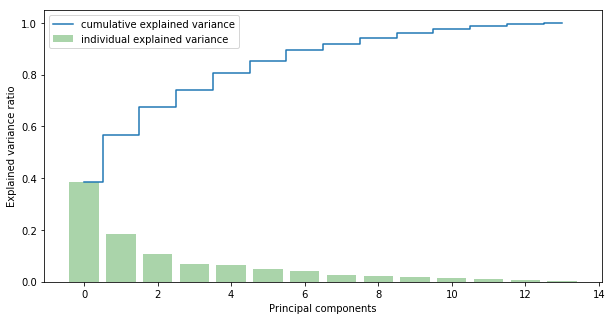

Cumulative explained ratio: [0.38437002 0.56761994 0.67381809 0.74165087 0.80467042 0.85308434
 0.89368856 0.91926452 0.94068013 0.9596849  0.97627595 0.98866249
 0.99678783 1.        ]


In [84]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(var_ratio)), 
        var_ratio, 
        alpha=0.3333, 
        align='center', 
        label='individual explained variance', 
        color = 'g')
plt.step(range(len(cum_var_ratio)),
         cum_var_ratio, 
         where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

cum_var_ratio = np.cumsum(var_ratio)
print("Cumulative explained ratio:",cum_var_ratio)

From the figure above, we can get that 

* the first two PCs explain 55.4% of variance;
* the first six PCs explain 85.1% of variance;

## Plot top two principal components

For the convenience of visualization, we choose the top two PCs in this part and plot the scatter plot with colored labels predicted by both K-Mean method and GMM method.

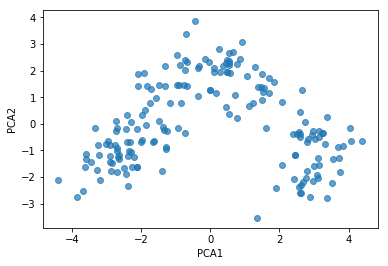

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Text(0.5,1,'Clusters of GMM in two PCs')

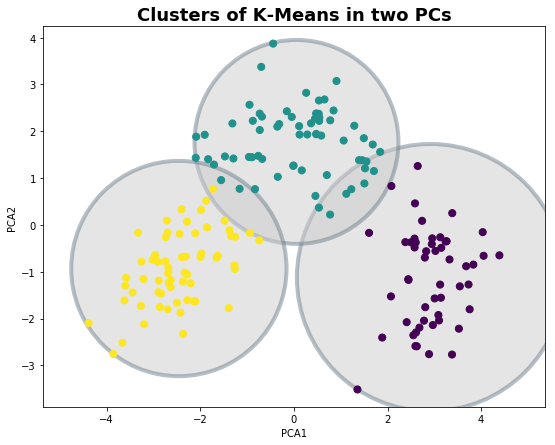

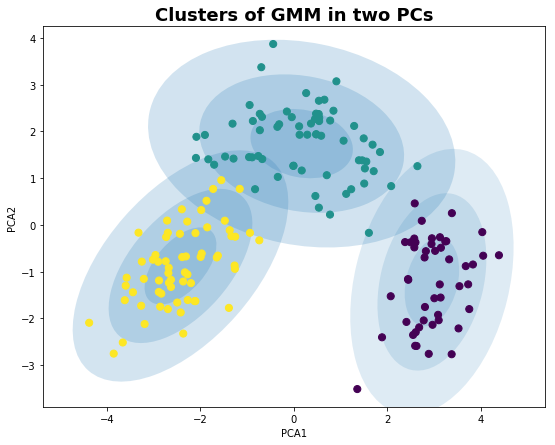

In [89]:
pca = PCA(n_components=2, random_state=seed)
pca.fit(winenorm)
winenorm_pca_array = pca.transform(winenorm)
winenorm_PCA = pd.DataFrame(winenorm_pca_array)
plt.scatter(x=winenorm_PCA.iloc[:,0], 
            y=winenorm_PCA.iloc[:,1], 
            alpha = 0.7)
plt.ylabel('PCA2')
plt.xlabel('PCA1')
plt.show()

# KM
KM = KMeans(n_clusters = 3, random_state=seed)
res_KM_PCA = KM.fit(winenorm_PCA)
label_pred_KM_PCA = KM.predict(winenorm_PCA)
plot_kmeans(KM, winenorm_PCA.as_matrix(),n_clusters=3)
plt.ylabel('PCA2')
plt.xlabel('PCA1')
plt.title('Clusters of K-Means in two PCs', fontsize=18, fontweight='demi')
# GMM
GMM = GaussianMixture(n_components = 3, random_state=seed)
res_GMM_PCA = GMM.fit(winenorm_PCA)
label_pred_GMM_PCA = GMM.predict(winenorm_PCA)
plot_gmm(GMM, winenorm_PCA.as_matrix())
plt.ylabel('PCA2')
plt.xlabel('PCA1')
plt.title('Clusters of GMM in two PCs', fontsize=18, fontweight='demi')

From the above three figures, we can easily figure out how K-Means and GMM method cluster the data.

Then we are going to plot the pair plots for the two PCs.

For the K-Means method:

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

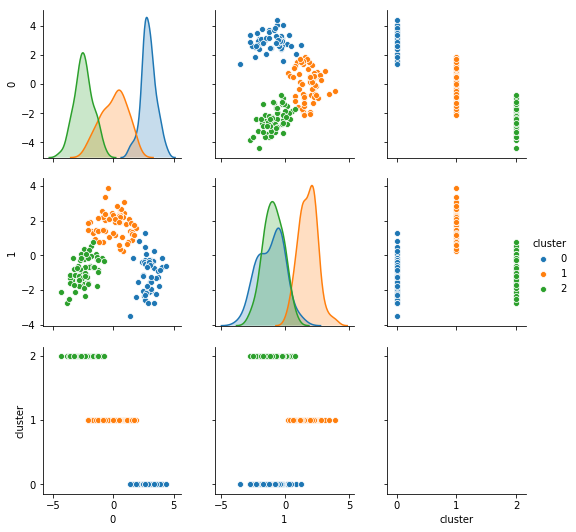

In [90]:
# Pairploy
## KM
winenorm_PCA['cluster'] = label_pred_KM_PCA.astype(str)
sns_plot = sns.pairplot(winenorm_PCA, hue = "cluster")

And for the GMM method:

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

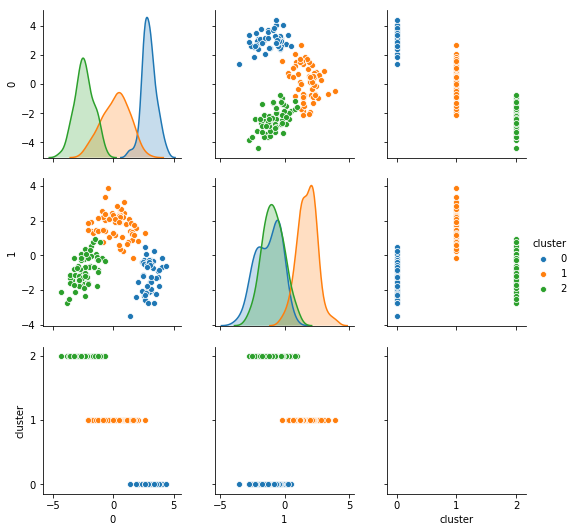

In [91]:
## GMM
winenorm_PCA['cluster'] = label_pred_GMM_PCA.astype(str)
sns_plot = sns.pairplot(winenorm_PCA, hue = "cluster")

# PCA and Cluster

In this part, we are going to select top six principal components and transform the dataset `winenorm`. Then we are going to run K-Means and GMM model on this dimension reduced dataset.

In [92]:
# we slecte six components
pca = PCA(n_components = 6, random_state=seed)
pca.fit(winenorm)
winenorm_pca_array = pca.transform(winenorm)
winenorm_PCA = pd.DataFrame(winenorm_pca_array)
var_ratio = pca.explained_variance_ratio_
print("Sum of top 6 PCs:",sum(var_ratio[0:5]))

# K-Means + PCA
KM = KMeans(n_clusters = 3, random_state=seed)
res = KM.fit(winenorm_PCA)
label_pred_KM_PCA = KM.predict(winenorm_PCA)
print("Labels predicted by KM+PCA:",label_pred_KM_PCA)

# GMM + PCA
GMM = GaussianMixture(n_components = 3, random_state=seed)
res_GMM = GMM.fit(winenorm_PCA)
label_pred_GMM_PCA = GMM.predict(winenorm_PCA)
print("Labels predicted by GMM+PCA:",label_pred_KM_PCA)

Sum of top 6 PCs: 0.8046704240372956
Labels predicted by KM+PCA: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels predicted by GMM+PCA: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

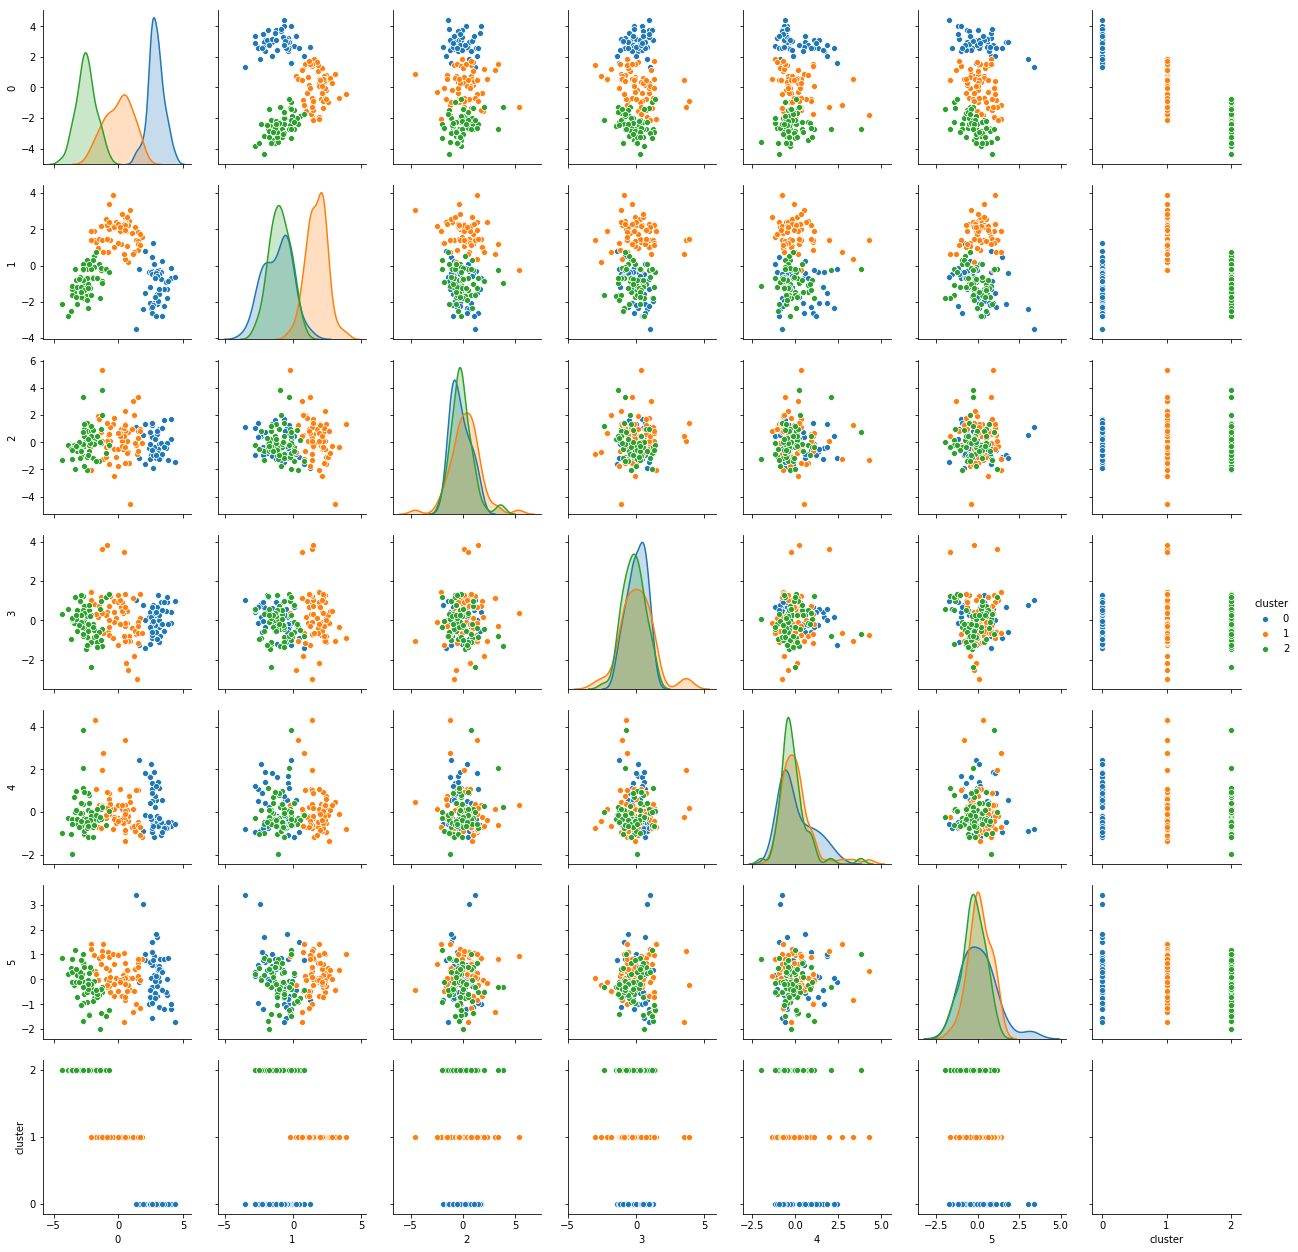

In [93]:
# Pairplot of KM
winenorm_PCA['cluster'] = label_pred_KM_PCA.astype(str)
sns_plot = sns.pairplot(winenorm_PCA, hue = "cluster")

/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(

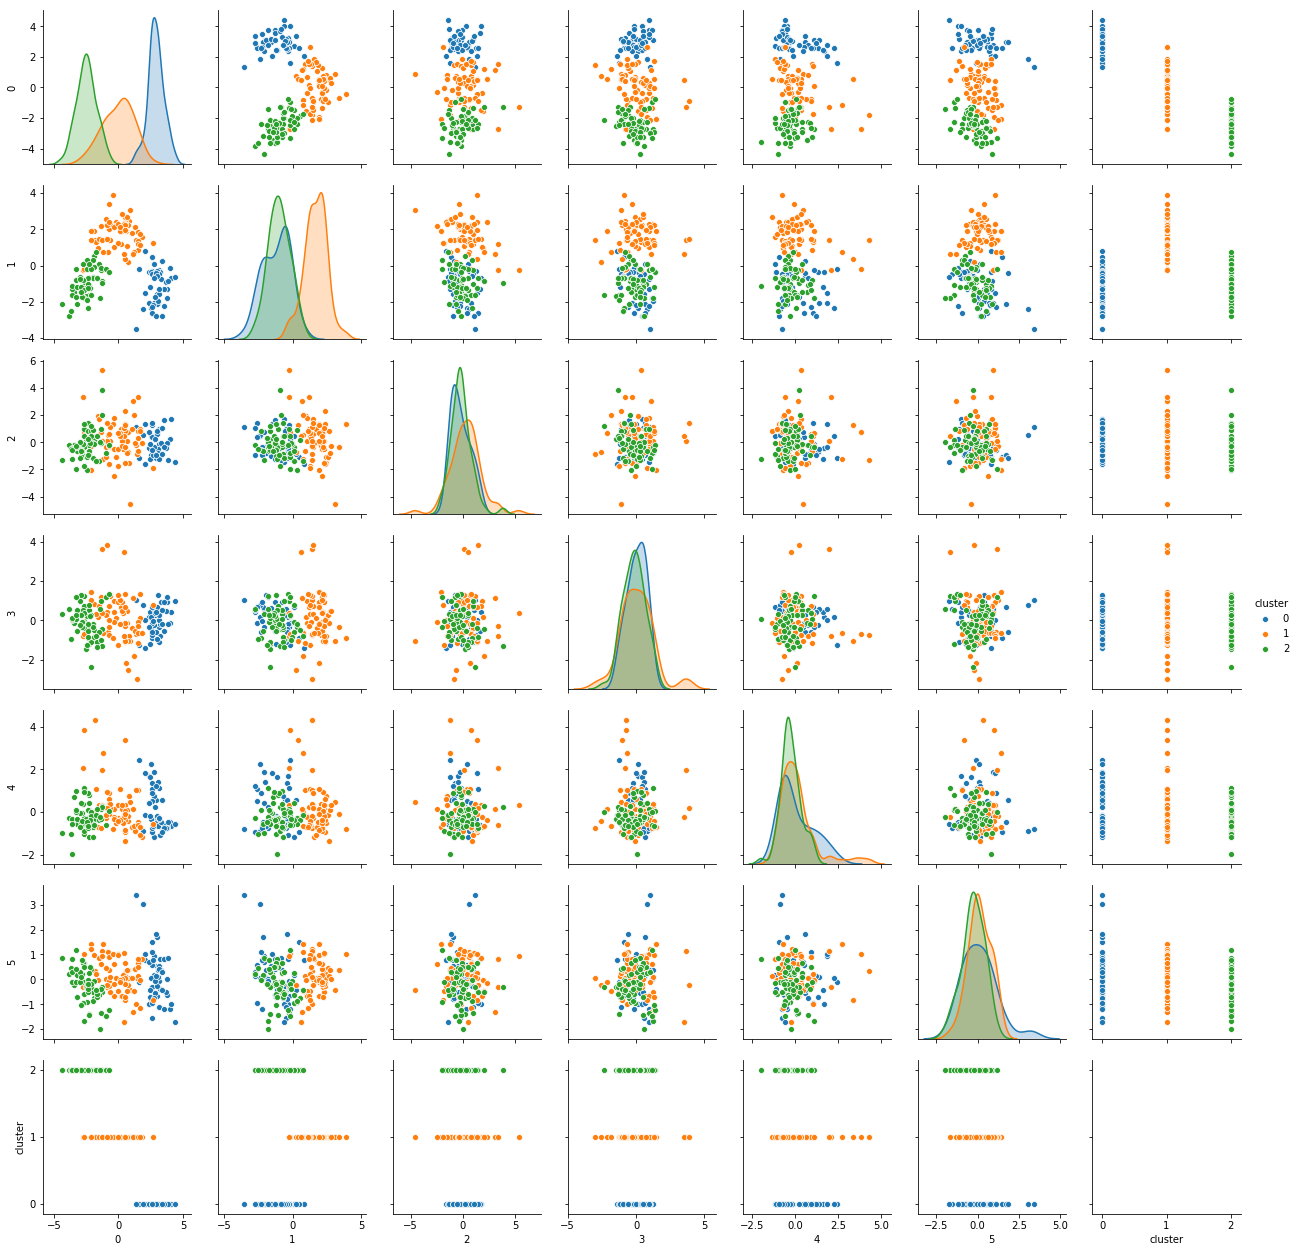

In [94]:
# Pairplot of GMM
winenorm_PCA['cluster'] = label_pred_GMM_PCA.astype(str)
sns_plot = sns.pairplot(winenorm_PCA, hue = "cluster")

# Evaluation

## Average [Silhouette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering))

Firstly, we use Silihouette score to evaluate the K-Means (KM), Gaussian Mixture Model (GMM), KM+PCA, GMM+PCA methods.

Silhouette score of cluster by KM: 0.301135931311762
Silhouette score of cluster by KM+PCA: 0.301135931311762
Silhouette score of cluster by GMM: 0.301135931311762
Silhouette score of cluster by GMM+PCA: 0.29783451509126274


/Users/huwei/anaconda/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


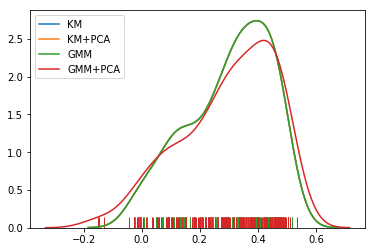

In [95]:
sh_score_KM = silhouette_score(winenorm, label_pred_KM)
print("Silhouette score of cluster by KM:",sh_score_KM)
sh_scores_KM = silhouette_samples(winenorm, label_pred_KM)
p1=sns.distplot(sh_scores_KM, hist=False, rug=True,label = 'KM');

sh_score_KM_PCA = silhouette_score(winenorm, label_pred_KM_PCA)
print("Silhouette score of cluster by KM+PCA:",sh_score_KM_PCA)
sh_scores_KM_PCA = silhouette_samples(winenorm, label_pred_KM_PCA)
p2=sns.distplot(sh_scores_KM_PCA, hist=False, rug=True, label = 'KM+PCA');

sh_score_GMM = silhouette_score(winenorm, label_pred_GMM)
print("Silhouette score of cluster by GMM:",sh_score_GMM)
sh_scores_GMM = silhouette_samples(winenorm, label_pred_GMM)
p3=sns.distplot(sh_scores_GMM, hist=False, rug=True, label = 'GMM');

sh_score_GMM_PCA = silhouette_score(winenorm, label_pred_GMM_PCA)
print("Silhouette score of cluster by GMM+PCA:",sh_score_GMM_PCA)
sh_scores_GMM_PCA = silhouette_samples(winenorm, label_pred_GMM_PCA)
p4=sns.distplot(sh_scores_GMM_PCA, hist=False, rug=True, label = 'GMM+PCA');

According to the average Silhouette score, it is hard to decide which model is the best model with highest score value.

## [Rand index](https://en.wikipedia.org/wiki/Rand_index) adjusted for chance

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:

`ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)`

We compare the predicted label with true label provided. Thus the higher the Rand Index, the more precise the cluster is.

In [96]:
ar_score_KM = adjusted_rand_score(label, label_pred_KM)
print("Adjusted Rand Index of cluster by KM:",ar_score_KM)

ar_score_KM_PCA = adjusted_rand_score(label, label_pred_KM_PCA)
print("Adjusted Rand Index of cluster by KM+PCA:",ar_score_KM_PCA)

ar_score_GMM = adjusted_rand_score(label, label_pred_GMM)
print("Adjusted Rand Index of cluster by GMM:",ar_score_GMM)

ar_score_GMM_PCA = adjusted_rand_score(label, label_pred_GMM_PCA)
print("Adjusted Rand Index of cluster by GMM+PCA:",ar_score_GMM_PCA)

Adjusted Rand Index of cluster by KM: 0.9148795960669529
Adjusted Rand Index of cluster by KM+PCA: 0.9148795960669529
Adjusted Rand Index of cluster by GMM: 0.9148795960669529
Adjusted Rand Index of cluster by GMM+PCA: 0.9667411092064137


**From the result above, we can conclude that the best model is GMM+PCA with the highest adjusted rand index value.**